Посмотрим работу HOG на одной из картинок дата-сета

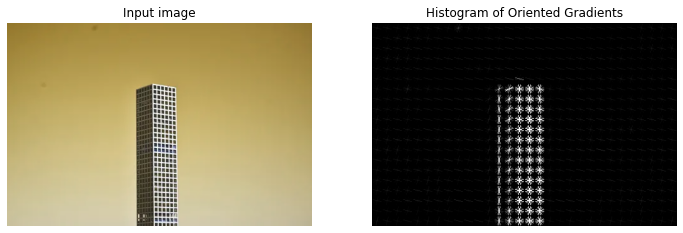

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import data, exposure
import cv2

image = cv2.imread('h1.jpg')
dim = (128, 64)
resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

Назовем картинки с небоскребами и частными домами positive_patches и загрузим их. Далее выполним предобработку: ресайз, чб

In [ ]:
from PIL import Image
import numpy as np
import glob
newsize = (128,64)
positive_patches = []
for filename in glob.glob('/content/drive/MyDrive/data_set_classification/high-rise_buildings/*.jpg'): #assuming gif
    img1=Image.open(filename)
    img1 = img1.resize(newsize)
    img1 = img1.convert('L')
    img1 = np.array(img1)
    positive_patches.append(img1)
for filename in glob.glob('/content/drive/MyDrive/data_set_classification/private_houses/*.jpg'): #assuming gif
    img1=Image.open(filename)
    img1 = img1.resize(newsize)
    img1 = img1.convert('L')
    img1 = np.array(img1)
    positive_patches.append(img1)
positive_patches = np.array(positive_patches)

In [ ]:
positive_patches.shape

(1036, 64, 128)

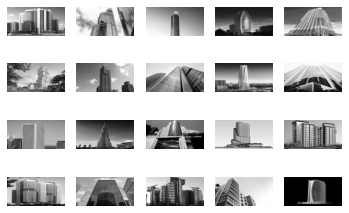

In [ ]:
fig, ax = plt.subplots(4,5)
for i, axi in enumerate(ax.flat):
    axi.imshow(positive_patches[10 * i], cmap='gray')
    axi.axis('off')

Картинки без домов и небоскребов назовем negative_patches, далее выполним аналогичные действия 

In [ ]:
from skimage import data, transform, color

imgs_to_use = ['hubble_deep_field', 'text', 'coins', 'moon',
               'page', 'clock','coffee','chelsea','horse']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  


In [ ]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape 

(27000, 64, 128)

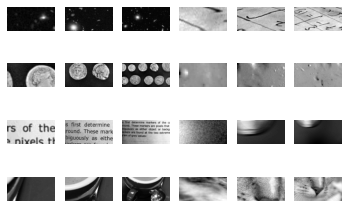

In [ ]:
fig, ax = plt.subplots(4,6)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[1000 * i], cmap='gray')
    axi.axis('off')

Разобьем набор данных на x_train y_train

In [ ]:
from skimage import feature   
from itertools import chain

X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

Классификацию будем выполнять алгоритмом SVM

C помощью gridSearch подберем оптимальные параметры

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV 

grid = GridSearchCV(LinearSVC(dual=False), {'C': [1.0, 2.0, 4.0, 8.0]},cv=3)
grid.fit(X_train, y_train)
grid.best_score_

0.9588735970227061

In [ ]:
grid.best_params_ 

{'C': 1.0}

Возьмем лучшую модель 

In [ ]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(dual=False)

Протестируем наш алогритм детекции 

In [ ]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=10, jstep=10, scale=1.5):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch

In [ ]:
img1 = cv2.imread("h6.jpg")


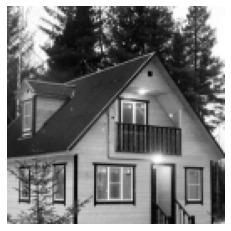

In [ ]:
test_img = img1
test_img = color.rgb2gray(test_img)
test_img = transform.rescale(test_img, 0.5)
test_img = test_img[:130, 50:180]
plt.imshow(test_img, cmap='gray')
plt.axis('off');

In [ ]:
indices, patches = zip(*sliding_window(test_img))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(16, 6804)

In [ ]:
labels = model.predict(patches_hog)
labels.sum()

5.0

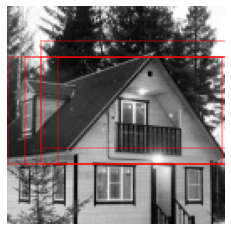

In [ ]:
fig, ax = plt.subplots()
ax.imshow(test_img, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))